In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

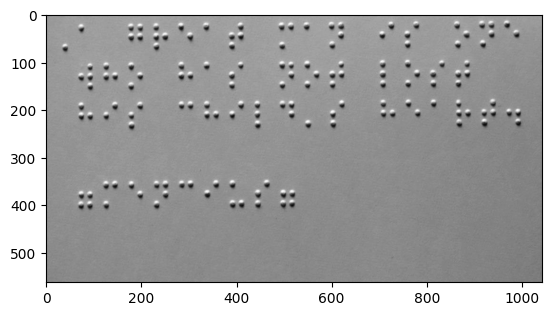

In [73]:
im = cv2.imread("braille1.jpg", flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap="gray")

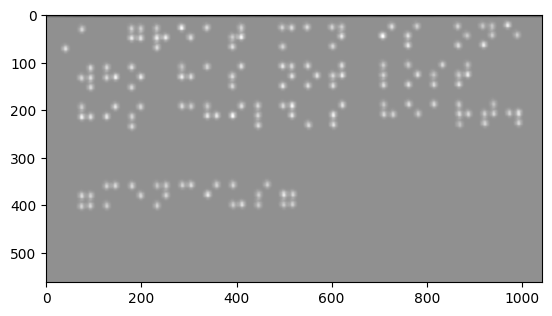

In [74]:
dst = cv2.cornerHarris(im, 12, 3, 0.04)
dst = cv2.dilate(dst, None)
dst = cv2.normalize(dst, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

plt.imshow(dst, cmap="gray")

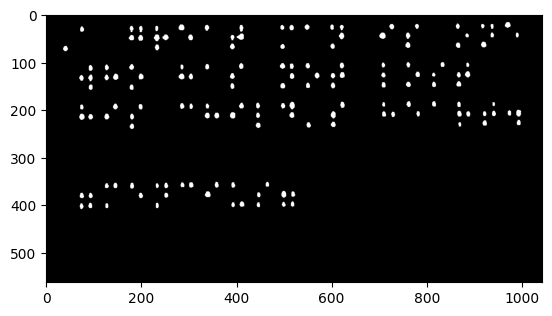

In [75]:
ret, dst_th = cv2.threshold(dst, 180, 255, cv2.THRESH_BINARY)
plt.imshow(dst_th, cmap="gray")

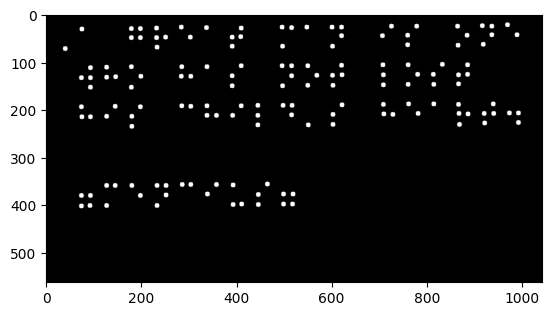

In [76]:
coutours, hierarchy = cv2.findContours(dst_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

dot_positions = []
for c in coutours:
    M = cv2.moments(c)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        dot_positions.append([cx, cy])

def image_with_dots(dot_positions, ref_image):
    blank_image = np.zeros_like(ref_image)
    for dot in dot_positions:
        cv2.circle(blank_image, dot, 5, 255, -1)
    return blank_image

image = image_with_dots(dot_positions, dst_th)
plt.imshow(image, cmap="gray")

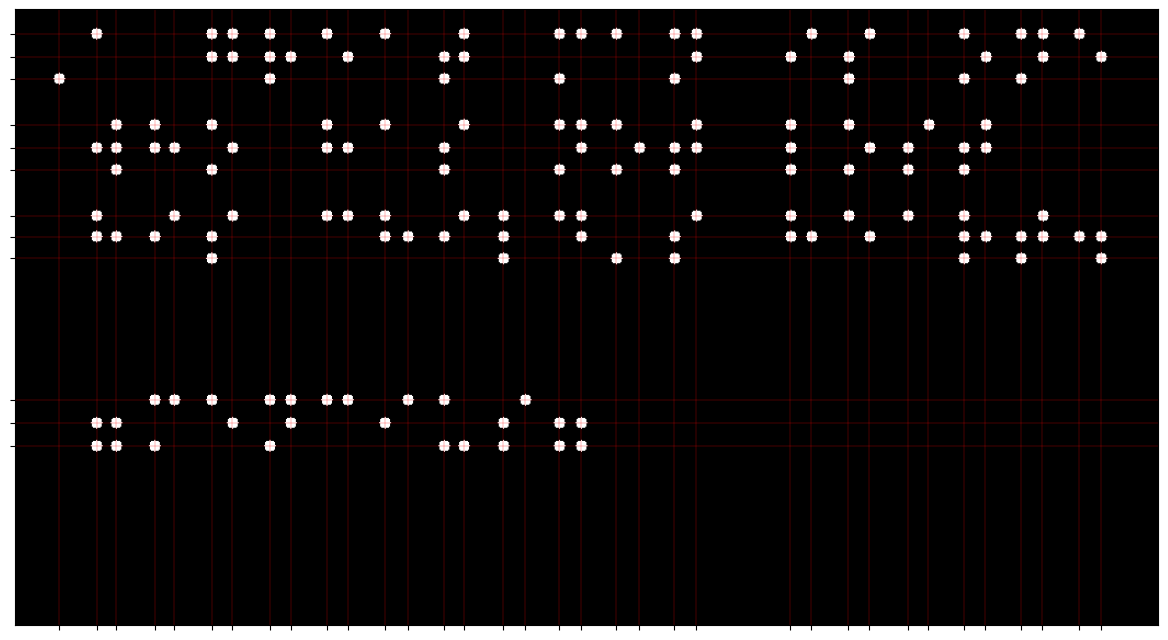

In [77]:
import copy
import itertools
import math

def dist(d1, d2):
    return (d1[0]-d2[0])**2 + (d1[1]-d2[1])**2

def get_min_dist(dot_positions):
    min_dist = dist(dot_positions[0], dot_positions[1])
    for dot1, dot2 in itertools.combinations(dot_positions, 2):
        d = dist(dot1, dot2)
        if d < min_dist:
            min_dist = d
    return math.sqrt(min_dist)

# aling along the grid
def aling(dot_positions):
    min_x = 0
    min_y = 0
    # distance between 2 closest dots
    min_dist = get_min_dist(dot_positions)

    while True:
        # all dots to be aligned
        all_y = [dot[1] for dot in dot_positions if dot[1] > min_y]
        if len(all_y) == 0:
            break
        # target y to align
        min_y = min(all_y)
        for i in range(len(dot_positions)):
            # dy is small enough to be considered the same row
            if dot_positions[i][1] > min_y and dot_positions[i][1] - min_y < min_dist * 0.6:
                dot_positions[i][1] = min_y

    while True:
        all_x = [dot[0] for dot in dot_positions if dot[0] > min_x]
        if len(all_x) == 0:
            break
        min_x = min(all_x)
        for i in range(len(dot_positions)):
            if dot_positions[i][0] > min_x and dot_positions[i][0] - min_x < min_dist * 0.6:
                dot_positions[i][0] = min_x

    return dot_positions

def enable_grid(ax, dot_positions):
    all_x = [dot[0] for dot in dot_positions]
    all_y = [dot[1] for dot in dot_positions]
    ax.set_xticks(list(set(all_x)))
    ax.set_yticks(list(set(all_y)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='r', linewidth=0.2)

dot_positions_aligned = aling(copy.deepcopy(dot_positions))
image = image_with_dots(dot_positions_aligned, dst_th)
plt.figure(figsize=(20, 8))
enable_grid(plt.gca(), dot_positions_aligned)
plt.imshow(image, cmap="gray")

In [78]:
def to_matrix(dot_positions):
    all_x = [dot[0] for dot in dot_positions]
    all_y = [dot[1] for dot in dot_positions]
    # unique x, y values
    sorted_x = list(set(all_x))
    sorted_y = list(set(all_y))
    sorted_x.sort()
    sorted_y.sort()

    dot_matrix = np.zeros((len(sorted_x), len(sorted_y)))
    for dot in dot_positions:
        matrix_x = sorted_x.index(dot[0])
        matrix_y = sorted_y.index(dot[1])
        dot_matrix[matrix_x, matrix_y] = 1

    dot_matrix = dot_matrix.transpose()
    return dot_matrix

# transform to matrix for comfortable processing
# 1 means dot present, 0 - not present
dot_matrix = to_matrix(dot_positions_aligned)
dot_matrix[0:5, 0:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 1., 1., 1., 1.]])

In [61]:
def hex_to_letter(hex):
    braille_dict = {
        0x01 : 'a',
        0x03 : 'b',
        0x09 : 'c',
        0x19 : 'd',
        0x11 : 'e',
        0x0B : 'f',
        0x1B : 'g',
        0x13 : 'h',
        0x0A : 'i',
        0x1A : 'j',
        0x05 : 'k',
        0x07 : 'l',
        0x0D : 'm',
        0x1D : 'n',
        0x15 : 'o',
        0x0F : 'p',
        0x1F : 'q',
        0x17 : 'r',
        0x0E : 's',
        0x1E : 't',
        0x25 : 'u',
        0x27 : 'v',
        0x3A : 'w',
        0x2D : 'x',
        0x3D : 'y',
        0x35 : 'z',
        # dict may be extended if needed
        0x04 : '\'',
        0x32 : '.',
        0x36 : '"'
    }
    if hex in braille_dict:
        return braille_dict[hex]
    else:
        return int(hex) # return hex for debugging

def get_hex(M, i, j, max_x, max_y):
    sum = M[i, j] * 1 + M[i + 1, j] * 2 + M[i + 2, j] * 4
    if j + 1 <= max_y:
        sum += M[i, j + 1] * 8 + M[i + 1, j + 1] * 16 + M[i + 2, j + 1] * 32
    return sum

def check_letter(M, i, j, max_x, max_y):
    return (i + 2 <= max_x and
           (M[i, j] == 1 or M[i + 1, j] == 1 or M[i + 2, j] == 1))

def check_capital(M, i, j, max_x, max_y):
    return (i + 2 <= max_x and
           (M[i, j] == 0 and M[i + 1, j] == 0 and M[i + 2, j] == 1) and
           (M[i, j + 1] == 1 or M[i + 1, j + 1] == 1 or M[i + 2, j + 1] == 1))

def erase_capital(M, i, j):
    M[i + 2, j] = 0

def erase_letter(M, i, j, max_x, max_y):
    M[    i, j] = 0
    M[i + 1, j] = 0
    M[i + 2, j] = 0
    if j + 1 <= max_y:
        M[    i, j + 1] = 0
        M[i + 1, j + 1] = 0
        M[i + 2, j + 1] = 0

def translate(M):
    max_x = M.shape[0] - 1
    max_y = M.shape[1] - 1

    i = 0
    capital = False
    while i < max_x:
        for j in range(max_y + 1):
            if check_letter(M, i, j, max_x, max_y): # check if we have something here
                if check_capital(M, i, j, max_x, max_y): # check for capital symbol (single dot)
                    capital = True
                    erase_capital(M, i, j) # erase capital symbol (single dot)
                    continue # continue and get letter at next step

                res = hex_to_letter(get_hex(M, i, j, max_y, max_y)) # translate
                if capital:
                    res = res.upper()
                    capital = False

                print(res, end=' ')
                erase_letter(M, i, j, max_x, max_y)
        i += 3 # letter is 3 lines height
        print()

translate(copy.deepcopy(dot_matrix))

A g r e a t m a n i s o n e 
w h o h a s n o t l o s t 
h i s c h i l d ' s h e a r t . 
" m e n c i u s " 


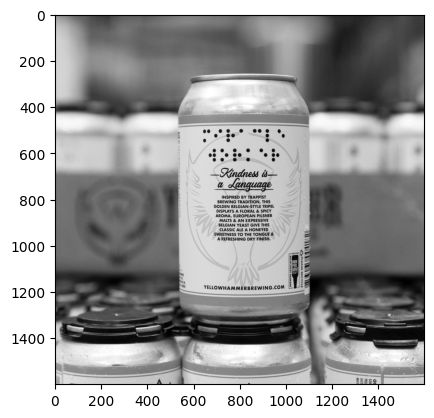

In [62]:
im = cv2.imread("braille2.jpg", flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap="gray")

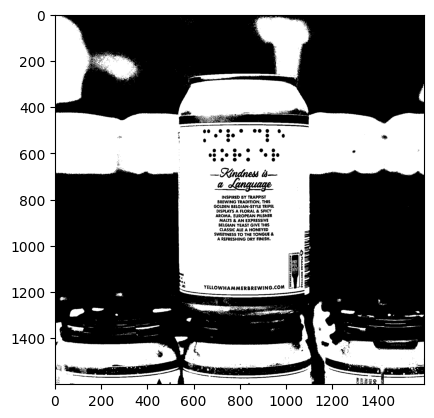

In [63]:
_, thresh = cv2.threshold(im, 150, 255, cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

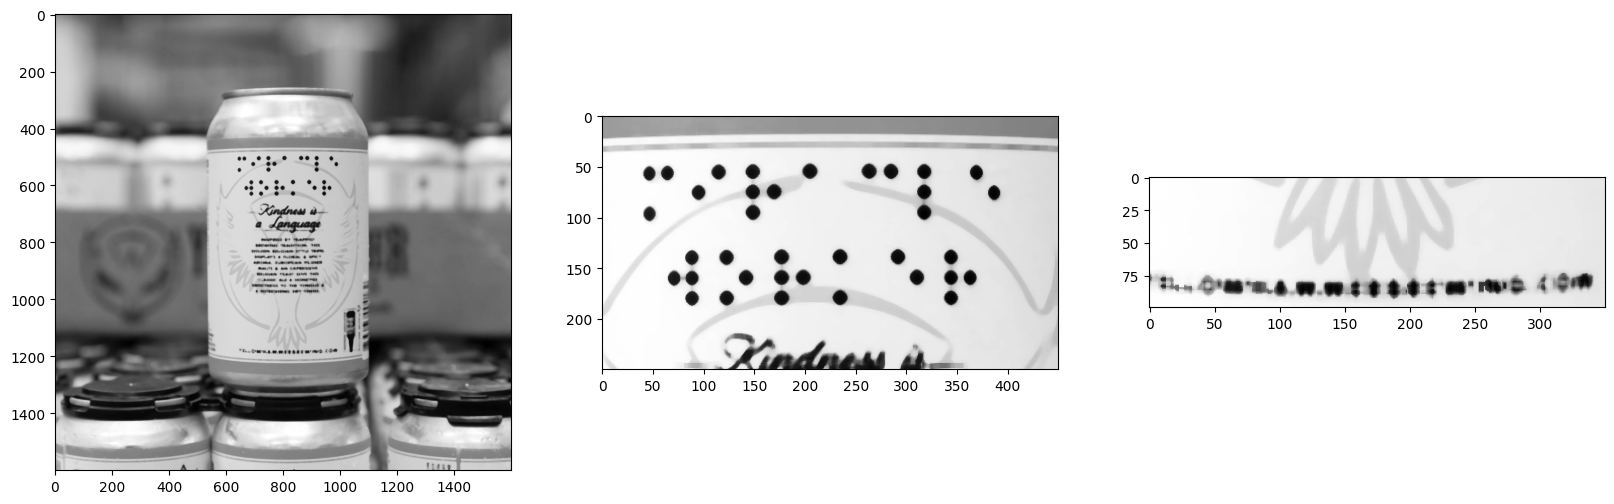

In [64]:
blur = cv2.medianBlur(im, 9)

f, axarr = plt.subplots(1, 3, figsize=(20, 8))
axarr[0].imshow(blur, cmap="gray")
axarr[1].imshow(blur[450:700, 600:1050], cmap="gray")
axarr[2].imshow(blur[1100:1200, 650:1000], cmap="gray")

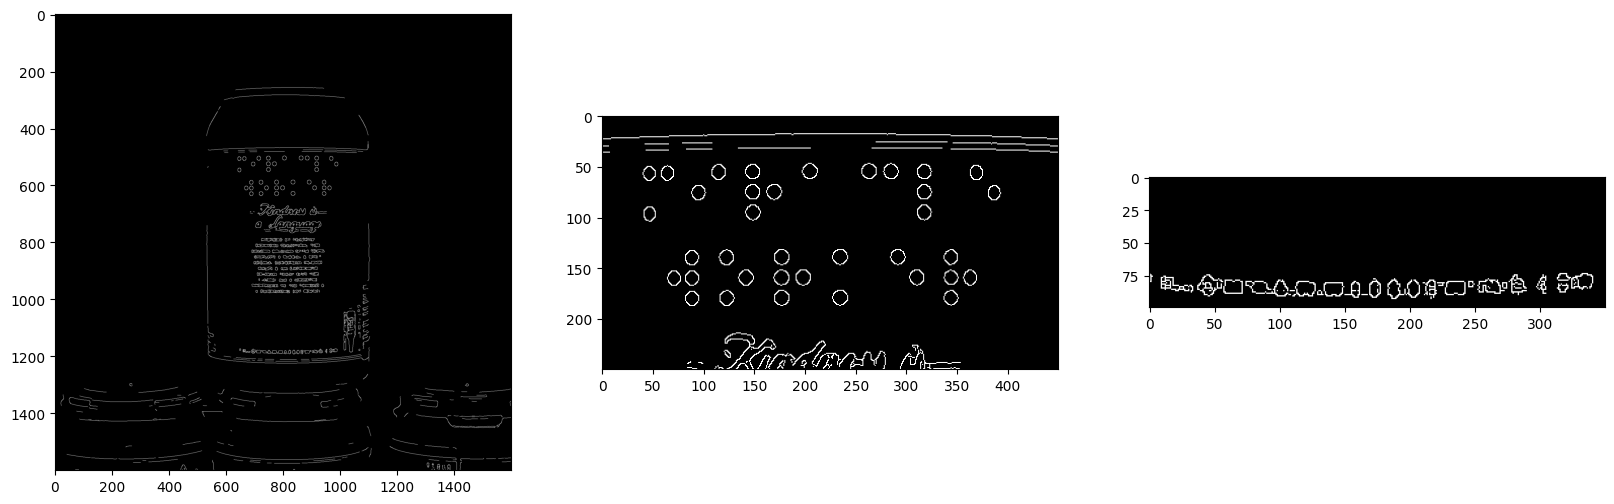

In [65]:
edges = cv2.Canny(blur, threshold1=150, threshold2=200)

f, axarr = plt.subplots(1, 3, figsize=(20, 8))
axarr[0].imshow(edges, cmap="gray")
axarr[1].imshow(edges[450:700, 600:1050], cmap="gray")
axarr[2].imshow(edges[1100:1200, 650:1000], cmap="gray")

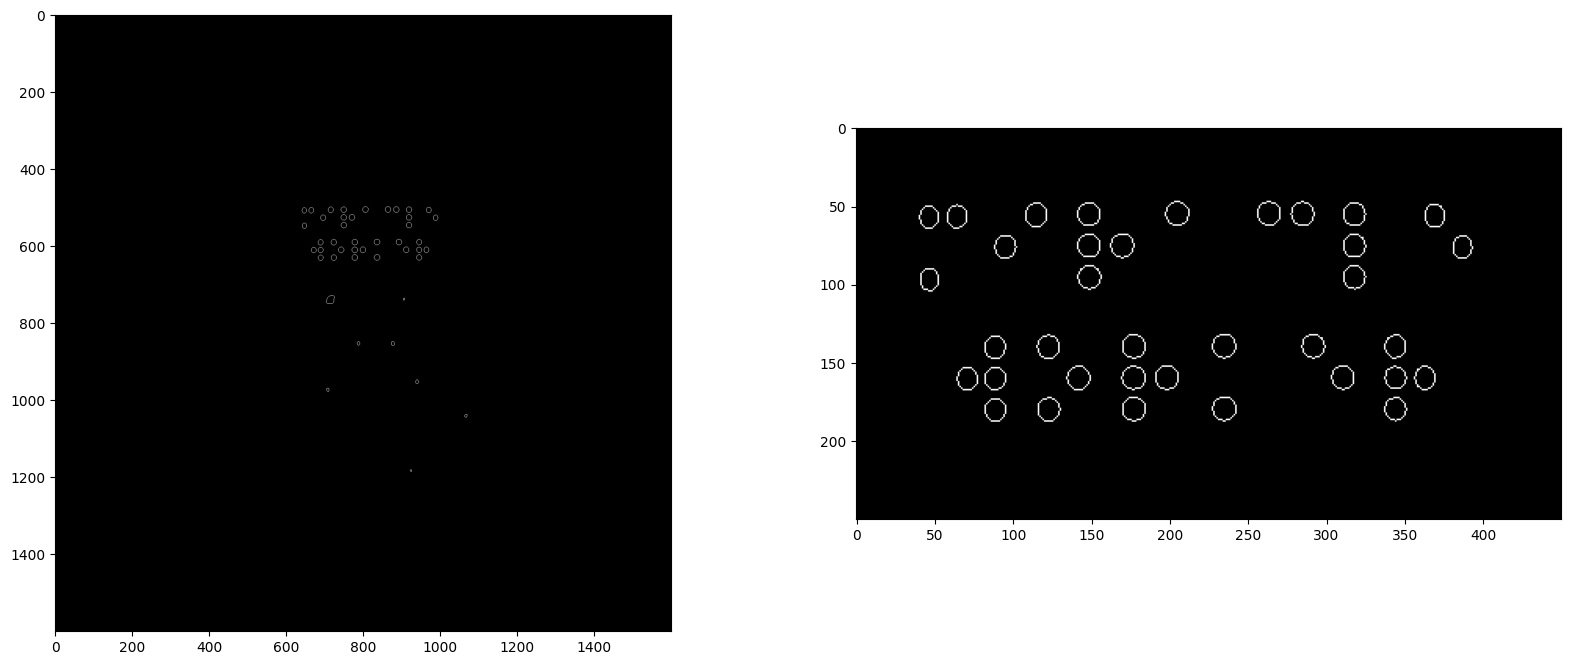

In [66]:
def countourIsCircle(contour):
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    if perimeter != 0:
        # geometry magic: area / perimeter^2 = 1/(4*pi)
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if 0.8 < circularity < 1.0:
            return True
    return False

coutours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# only circles
coutours = [c for c in coutours if countourIsCircle(c)]

blank = np.zeros_like(edges)
cv2.drawContours(blank, coutours, -1, (255, 0, 0), 1)

f, axarr = plt.subplots(1, 2, figsize=(20, 8))
axarr[0].imshow(blank, cmap="gray")
axarr[1].imshow(blank[450:700, 600:1050], cmap="gray")

(array([ 4.,  3.,  0., 10., 26.,  0.,  0.,  0.,  0.,  1.]),
 array([ 11.5 ,  45.65,  79.8 , 113.95, 148.1 , 182.25, 216.4 , 250.55,
        284.7 , 318.85, 353.  ]),
 <BarContainer object of 10 artists>)

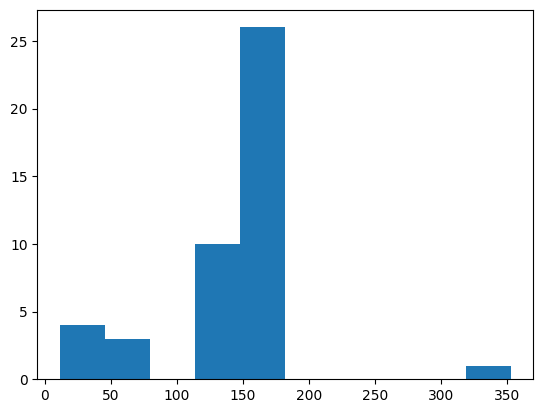

In [67]:
area = [cv2.contourArea(c) for c in coutours]
plt.hist(area)

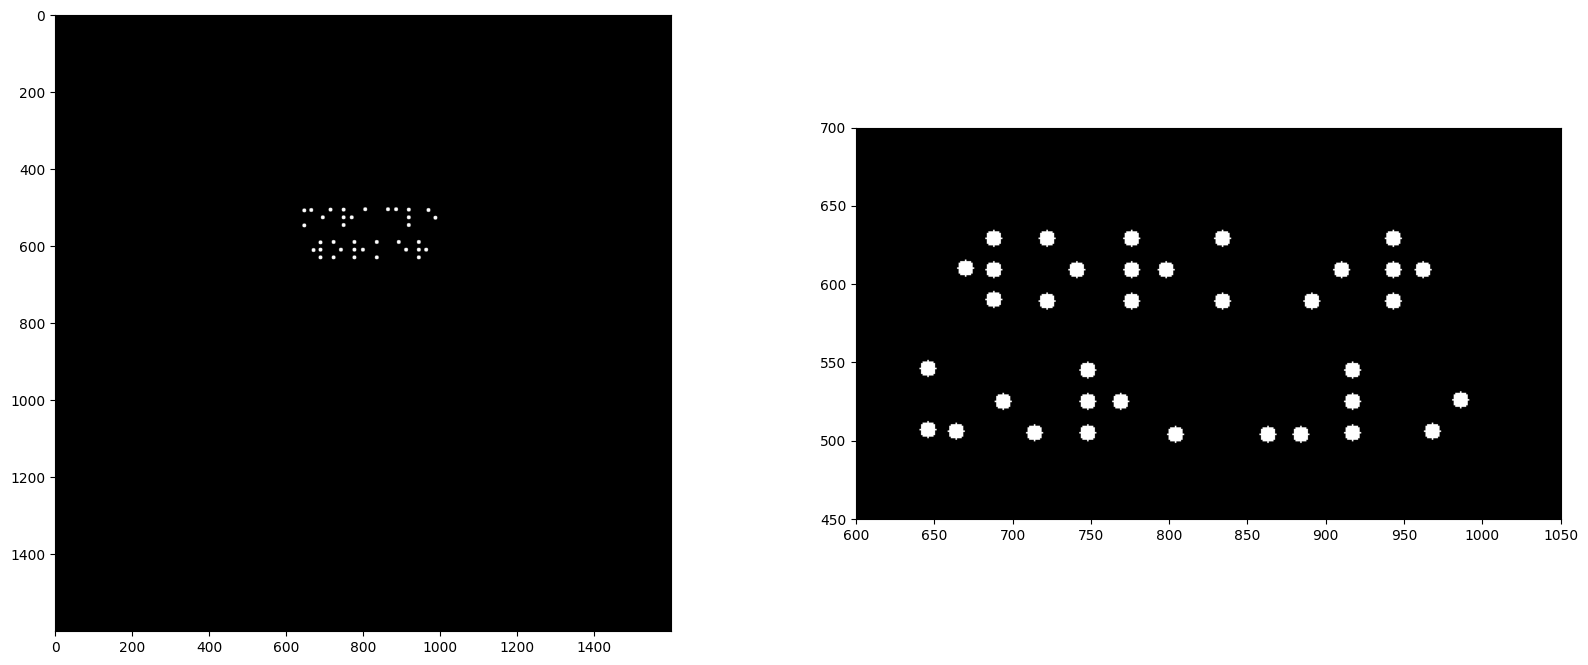

In [68]:
dot_positions = []
for c in coutours:
    area = cv2.contourArea(c)
    if 110 < area < 190:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            dot_positions.append([cx, cy])

image = image_with_dots(dot_positions, edges)
f, axarr = plt.subplots(1, 2, figsize=(20, 8))
axarr[0].imshow(image, cmap="gray")

axarr[1].set_xlim([600, 1050])
axarr[1].set_ylim([450, 700])
axarr[1].imshow(image, cmap="gray")

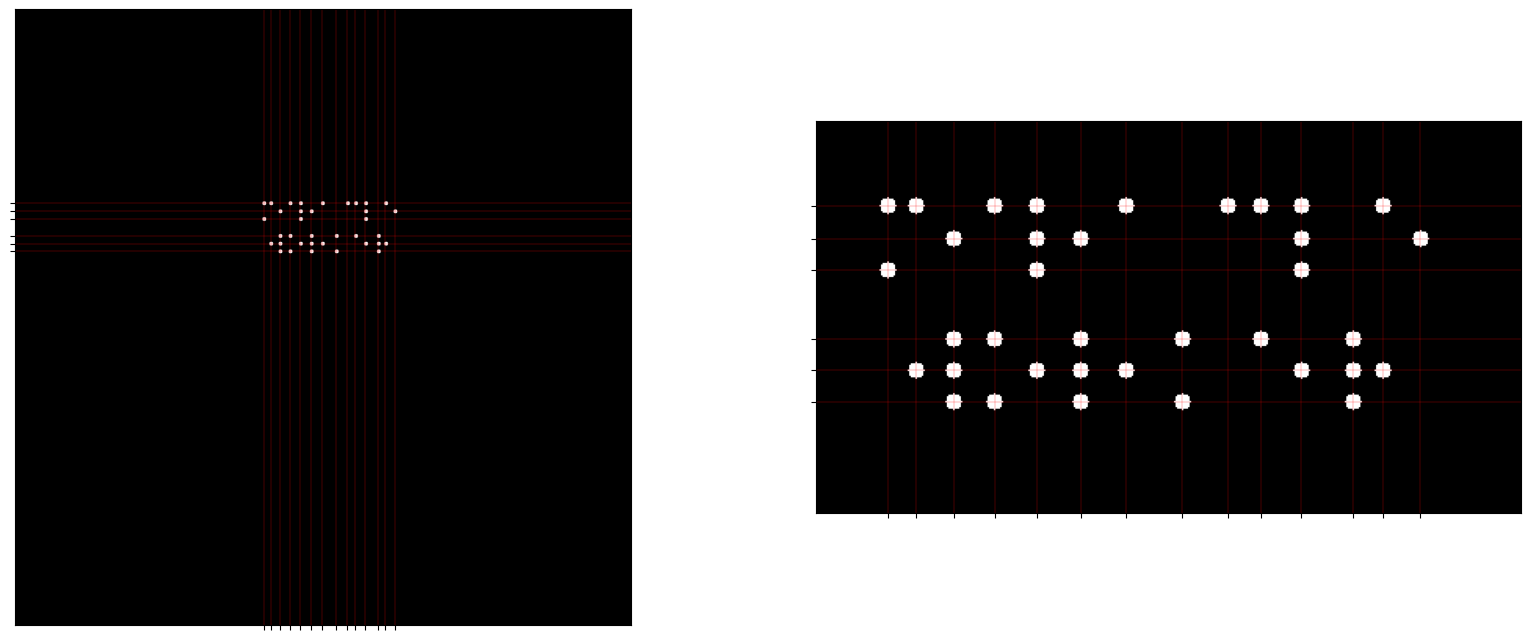

In [69]:
dot_positions_aligned = aling(copy.deepcopy(dot_positions))
image = image_with_dots(dot_positions_aligned, edges)

f, axarr = plt.subplots(1, 2, figsize=(20, 8))
enable_grid(axarr[0], dot_positions_aligned)
axarr[0].imshow(image, cmap="gray")

axarr[1].set_xlim([600, 1050])
axarr[1].set_ylim([700, 450])
enable_grid(axarr[1], dot_positions_aligned)
axarr[1].imshow(image, cmap="gray")

In [70]:
dot_matrix = to_matrix(dot_positions_aligned)
translate(copy.deepcopy(dot_matrix))

m i r a c l e 
w o r k e r 
